# Using ctools from Python

In this notebook you will learn how to use the ctools and cscripts from Python instead of typing the commands in the console.

ctools provides two Python modules that allow using all tools and scripts as Python classes. To use ctools from Python you have to import the `ctools` and `cscripts` modules into Python. You should also import the `gammalib` module, as ctools without GammaLib is generally not very useful.

__Warning:__ Always import `gammalib` before you import `ctools` and `cscripts`.

In [3]:
import gammalib
import ctools
import cscripts
print('gammalib version: {}'.format(gammalib.__version__))
print('ctools version: {}'.format(ctools.__version__))
print('csscripts version: {}'.format(cscripts.__version__))

gammalib version: 1.5.1
ctools version: 1.5.1
csscripts version: 1.5.1


In [6]:
!echo $CTOOLS

/Users/giovanni/anaconda3/envs/ctools


## Simulating events

As an example we will simulate an observation of an hour of the Crab nebula.

In [30]:
sim = ctools.ctobssim()
sim['inmodel']   = '${CTOOLS}/share/models/crab.xml'
sim['outevents'] = 'events.fits'
sim['caldb']     = 'prod2'
sim['irf']       = 'South_0.5h'
sim['ra']        = 83.5
sim['dec']       = 22.8
sim['rad']       = 5.0
sim['tmin']      = gammalib.GTime('2020-01-01T00:00:00') 
sim['tmax']      = gammalib.GTime('2020-01-01T01:00:00')
sim['emin']      = 0.03
sim['emax']      = 150.0
sim.execute()

The first line generates an instance of the ctobssim tool as a Python class. User parameters are then set using the `[ ]` operator. After setting all parameters the `execute()` method is called to execute the `ctobssim` tool. On output the `events.fits` FITS file is created. Until now everything is analogous to running the tool from the command line, but in Python you can easily combine the different blocks into more complex workflows.

Remember that you can consult the manual of each tool to find out how it works and to discover all the input parameters that you can set.

In [5]:
!ctobssim --help


ctobssim

Simulate event list(s).


Synopsis
--------

This tool simulates event list(s) using the instrument characteristics 
specified by the instrument response function(s) and an input model. The 
simulation includes photon events from astrophysical sources and background
events from an instrumental background model.

By default, ctobssim creates a single event list. ctobssim queries a pointing
direction, the radius of the simulation region, a time interval, an energy
interval, an instrumental response function, and an input model. ctobssim uses
a numerical random number generator for the simulations with a seed value
provided by the hidden seed parameter. Changing this parameter for
subsequent runs will lead to different event samples.

ctobssim performs a safety check on the maximum photon rate for all model
components to avoid that the tool locks up and requests huge memory 
resources, which may happen if a mistake was made in setting up the input 
model (for example if an erro

In a Jupyter notebook a code line starting with `!` is executed in the shell, so you can do the operation above just from the command line.

One of the advantages of using ctools from Python is that you can run a tool using

In [31]:
sim.run()

The main difference to the `execute()` method is that the `run()` method will not write the output (i.e., the simulated event list) to disk. Why is this useful? Well, after having typed `sim.run()` the `ctobssim` class still exists as an object in memory, including all the simulated events. You can always save to disk later using the `save()` method.

The `ctobssim` class has an `obs()` method that returns an observation container that holds the simulated CTA observation with its associated events. To visualise this container, type:

In [32]:
print(sim.obs())

=== GObservations ===
 Number of observations ....: 1
 Number of models ..........: 2
 Number of observed events .: 200741
 Number of predicted events : 0


There is one CTA observation in the container and to visualise that observation type:

In [33]:
print(sim.obs()[0])

=== GCTAObservation ===
 Name ......................: 
 Identifier ................: 000001
 Instrument ................: CTA
 Event file ................: events.fits
 Event type ................: EventList
 Statistic .................: cstat
 Ontime ....................: 3599.99999976158 s
 Livetime ..................: 3527.99999976635 s
 Deadtime correction .......: 0.98
 User energy range .........: undefined
=== GCTAPointing ===
 Pointing direction ........: (RA,Dec)=(83.5,22.8)
=== GCTAResponseIrf ===
 Caldb mission .............: cta
 Caldb instrument ..........: prod2
 Response name .............: South_0.5h
 Energy dispersion .........: Not used
 Save energy range .........: undefined
=== GCTAEventList ===
 Number of events ..........: 200741 (disposed in "events.fits")
 Time interval .............: 58849.0008007407 - 58849.0424674074 days
 Energy interval ...........: 0.03 - 150 TeV
 Region of interest ........: RA=83.5, DEC=22.8 [0,0] Radius=5 deg
=== GSkyRegions ===
 Number

The observation contains a CTA event list that is implement by the GammaLib class `GCTAEventList`. You can access the event list using the `events()` method. To visualise the individual events you can iterate over the events using a for loop. This will show the simulated celestial coordinates `(RA, DEC)`, the coordinate in the camera system `[DETX, DETY]`, the energies and the terrestrial times (TT) of all events. Let's peek at the first events of the list:

In [35]:
events = sim.obs()[0].events()
for event in events[:3]:
    print(event)

Dir=RA=83.7821807861328, DEC=22.0288944244385 [-0.0134540141482956,0.00456559645656115] Energy=36.9588024914265 GeV Time=315532804.286922 s (TT)
Dir=RA=83.3642120361328, DEC=21.9072818756104 [-0.0155798772869648,-0.00219893960278778] Energy=44.534046202898 GeV Time=315532804.621977 s (TT)
Dir=RA=84.1257400512695, DEC=22.2384223937988 [-0.00978014909472036,0.0101090619729128] Energy=33.5247628390789 GeV Time=315532807.816652 s (TT)


We can use this feature to inspect some of the event properties, for example look at their energy spectrum. For this we will use the Python packages matplotlib. If you do not have matplotlib you can use another plotting package of your choice or skip this step.

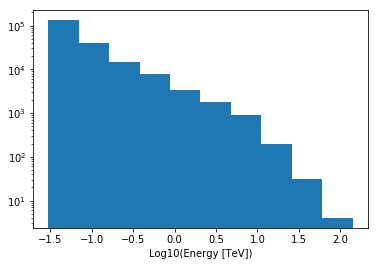

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline
#this will visualize plots inline

ax = plt.subplot()
ax.set_yscale('log')
ax.set_xlabel('Log10(Energy [TeV])')

energies = []
for event in events:
    energies.append(event.energy().log10TeV())
    
n, bins, patches = plt.hist(energies)

## Fitting a model to the observations

We can use the observation in memory to directly run a likelihood fit.

In [37]:
like = ctools.ctlike(sim.obs())
like.run()

This is very compact. Where do we define the model fit to the data? Where are the user parameters? `ctlike` doesn’t in fact need any parameters as all the relevant information is already contained in the observation container produced by the ctobssim class. Indeed, you constructed the ctlike instance by using the ctobssim observation container as constructor argument.

An observation container, implemented by the `GObservations` class of GammaLib, is the fundamental brick of any ctools analysis. An observation container can hold more than events, e.g., in this case it also holds the model that was used to generate the events.

Many tools and scripts handle observation containers, and accept them upon construction and return them after running the tool via the `obs()` method. Passing observation containers between ctools classes is a very convenient and powerful way of building in-memory analysis pipelines. However, this implies that you need some computing ressources when dealing with large observation containers (for example if you want to analyse a few 100 hours of data at once). Also, if the script crashes the information is lost.

To check how the fit went you can inspect the optimiser used by `ctlike` by typing:

In [38]:
print(like.opt())

=== GOptimizerLM ===
 Optimized function value ..: 755051.482
 Absolute precision ........: 0.005
 Acceptable value decrease .: 2
 Optimization status .......: converged
 Number of parameters ......: 10
 Number of free parameters .: 4
 Number of iterations ......: 2
 Lambda ....................: 1e-05


You see that the fit converged after 2 iterations. Out of 10 parameters in the model 4 have been fitted (the others were kept fixed). To inspect the fit results you can print the model container that can be access using the `models()` method of the observation container:

In [39]:
print(like.obs().models())

=== GModels ===
 Number of models ..........: 2
 Number of parameters ......: 10
=== GModelSky ===
 Name ......................: Crab
 Instruments ...............: all
 Instrument scale factors ..: unity
 Observation identifiers ...: all
 Model type ................: PointSource
 Model components ..........: "PointSource" * "PowerLaw" * "Constant"
 Number of parameters ......: 6
 Number of spatial par's ...: 2
  RA .......................: 83.6331 [-360,360] deg (fixed,scale=1)
  DEC ......................: 22.0145 [-90,90] deg (fixed,scale=1)
 Number of spectral par's ..: 3
  Prefactor ................: 5.69396634052842e-16 +/- 6.14427401423559e-18 [1e-23,1e-13] ph/cm2/s/MeV (free,scale=1e-16,gradient)
  Index ....................: -2.4703556883579 +/- 0.00792538918685176 [-0,-5]  (free,scale=-1,gradient)
  PivotEnergy ..............: 300000 [10000,1000000000] MeV (fixed,scale=1000000,gradient)
 Number of temporal par's ..: 1
  Normalization ............: 1 (relative value) (fixed,sca

For example, in this way we can fetch the minimum of the optimized function (the negative of the natural logarithm of the likelihood) to compare different model hypotheses.

In [40]:
like1 = like.opt().value()
print(like1)

755051.4819615572


Suppose you want to repeat the fit by optimising also the position of the point source. This is easy from Python, as you can modify the model and fit interactively. Type the following:

In [41]:
like.obs().models()['Crab']['RA'].free()
like.obs().models()['Crab']['DEC'].free()
like.run()
print(like.obs().models())

=== GModels ===
 Number of models ..........: 2
 Number of parameters ......: 10
=== GModelSky ===
 Name ......................: Crab
 Instruments ...............: all
 Instrument scale factors ..: unity
 Observation identifiers ...: all
 Model type ................: PointSource
 Model components ..........: "PointSource" * "PowerLaw" * "Constant"
 Number of parameters ......: 6
 Number of spatial par's ...: 2
  RA .......................: 83.6324977668637 +/- 0.000645834980167342 [-360,360] deg (free,scale=1)
  DEC ......................: 22.0156097018479 +/- 0.000603833638486857 [-90,90] deg (free,scale=1)
 Number of spectral par's ..: 3
  Prefactor ................: 5.69123259664292e-16 +/- 6.14234382363775e-18 [1e-23,1e-13] ph/cm2/s/MeV (free,scale=1e-16,gradient)
  Index ....................: -2.47037429659339 +/- 0.00792634862711166 [-0,-5]  (free,scale=-1,gradient)
  PivotEnergy ..............: 300000 [10000,1000000000] MeV (fixed,scale=1000000,gradient)
 Number of temporal par'

Now we can quantify the improvement of the model by comparing the new value of the optimized function with the previous one.

In [42]:
like2 = like.opt().value()
ts    = -2.0 * (like2 - like1)
print(ts)

4.275719205150381


The test statistic (TS) is expected to be distributed as a $\chi^2_n$ with a number of degrees of freedom $n$ equal to the additional number of degrees of freedom of the (second) more complex model with respect to the (first) more parsimonious one, for our case two degrees of freedom. The chance probability that the likelihood improved that much because of pure statistical fluctuations is the integral from TS to infinity of the chi square with two degrees of freedom. In this case the improvement is negligible (i.e., the chance probability is very high), as expected since in the model the source is already at the true position.